In [1]:
!pip install bing-image-downloader

In [2]:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
from pathlib import Path
import os
from bing_image_downloader import downloader
path = Path('/gdrive/MyDrive/art_recommendation')
os.makedirs(path, exist_ok=True)
os.listdir(path)
# you only need to define artist name
artist_name = 'leonardo da vinci'
folder_path = path / artist_name


os.makedirs(folder_path, exist_ok=True)

In [ ]:
# try appending 'art', 'artwork', 'paintings', 'ouvre', 'works',
# 'famous paintings', 'less famous work', to your search

downloader.download(f"{artist_name} artworks", limit=500,
                    output_dir=folder_path,
                    adult_filter_off=True,
                    force_replace=False,
                    timeout=60)

In [5]:

os.listdir(folder_path)

['leonardo da vinci artworks']

In [6]:
from pathlib import Path
import shutil

# Define the source and destination directories
source_dir = folder_path
destination_dir = folder_path / 'paintings'

# Create the destination directory if it doesn't exist
destination_dir.mkdir(parents=True, exist_ok=True)

# Iterate through all subdirectories in the source directory
for subdir in source_dir.iterdir():
    if subdir.is_dir():
        # Iterate through all JPG files in each subdirectory
        for file in subdir.glob("*.jpg"):
            # Construct new file name with folder name as prefix
            new_file_name = f"{subdir.name}_{file.name}"
            new_file_path = destination_dir / new_file_name

            # Move and rename each file to the destination directory
            shutil.move(str(file), new_file_path)

In [7]:
from pathlib import Path
import os
artist_name = 'leonardo da vinci'
path = Path(f'/gdrive/MyDrive/art_recommendation/{artist_name}')

In [8]:
import skimage.io as io
from PIL import Image

image_paths = os.listdir(path / "paintings")
img_array =io.imread(path / "paintings" / image_paths[0])
img_array.shape

(1627, 1200, 3)

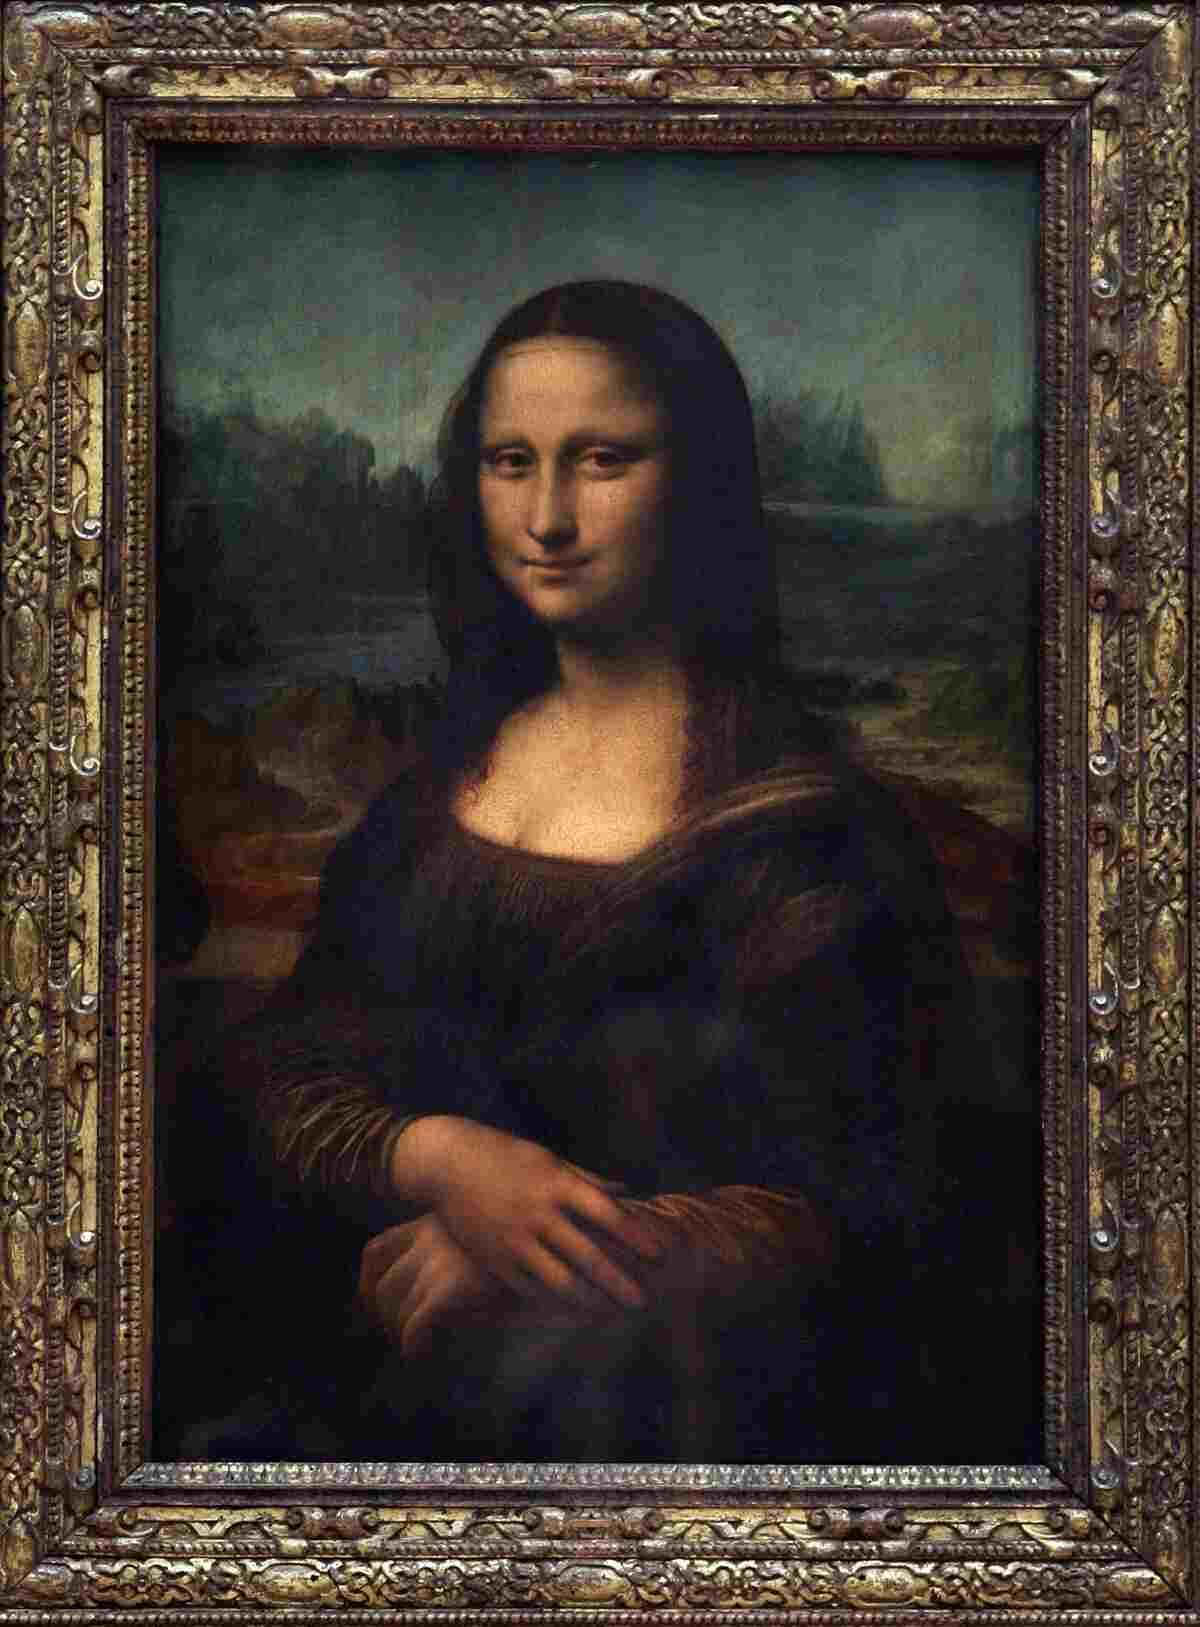

In [9]:
image = Image.fromarray(img_array)
image

In [10]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet34_Weights
from PIL import Image

# Load the pretrained ResNet34 model
model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# Remove the final classification layer to get embeddings
# The output is now 512 dimensional embedding for any input image.
model = torch.nn.Sequential(*list(model.children())[:-1])

# Set model to evaluation mode
model.eval()

# Define the image transformation
# Prepare the input image to match ImageNet training settings: 224x224 size
# converts to tensors + normalise using imageNet mean and std
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Function to extract embeddings from an image
def extract_embedding(image):
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(image)
    return embedding.squeeze().numpy()

# Example usage
embedding = extract_embedding(image)
print(embedding.shape)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]


(512,)


In [11]:
from tqdm import tqdm
import io
paintings_embedded_dict = {}
from PIL import UnidentifiedImageError

corrupted_files = []
for filename in tqdm(os.listdir(path / "paintings")):
  try:
    # Use io.BytesIO to read the image file as bytes
    with open(path / "paintings" / filename, 'rb') as f:
      image_bytes = io.BytesIO(f.read())
    # Open the image using Pillow and ensure it is in RGB mode
    image = Image.open(image_bytes).convert("RGB")
    embedding = extract_embedding(image) #generate embeddings
    paintings_embedded_dict[path / "paintings" / filename] = embedding
  # Handle errors
  except (IOError, UnidentifiedImageError) as e:
    print(f"Skipping file {filename} due to error: {e}")
    corrupted_files.append(path / "paintings" / filename)



100%|██████████| 283/283 [01:12<00:00,  3.91it/s]


In [ ]:
for i, (path, embedding) in enumerate(paintings_embedded_dict.items()):
    print(f"{path} → shape: {embedding.shape}")
    if i == 4:
        break

In [ ]:
for i, (path, embedding) in enumerate(paintings_embedded_dict.items()):
    print(f"{path} → embedding: {embedding}")
    if i == 4:
        break

In [12]:
# Delete corrupted files
for file_path in corrupted_files:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting {file_path}: {e}")

In [13]:
# These lengths should be equal - check all remaining files are valid and embedded
assert len(paintings_embedded_dict) == len(os.listdir(path / "paintings"))

In [14]:
# check out the integrity of our pickle file
import pickle
## save the paintings embeddings to a .pickle file
with open(path / 'paintings_embeddings.pickle', 'wb') as handle:
    pickle.dump(paintings_embedded_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path / 'paintings_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

assert len(b.keys()) == len(paintings_embedded_dict.keys())

In [15]:
# These should be fully formed paths, we should be able to open all of these images
# from Google Drive
b.keys()

dict_keys([PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_1.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_2.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_4.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_5.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_6.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_7.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artworks_Image_8.jpg'), PosixPath('/gdrive/MyDrive/art_recommendation/leonardo da vinci/paintings/paintings_leonardo da vinci artwo

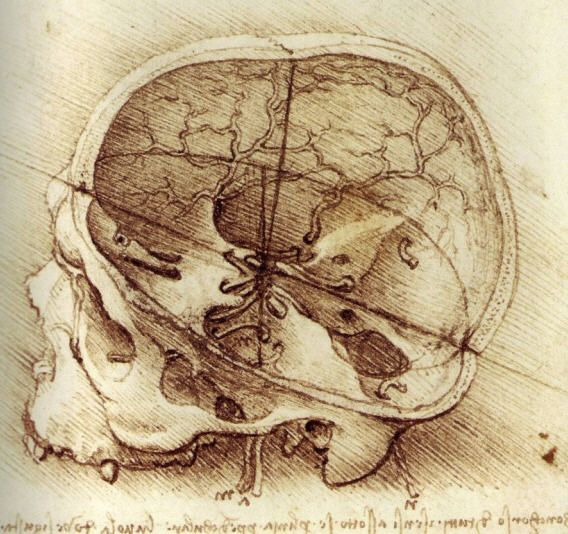

In [16]:
# Check that the keys correspond to valid paths
Image.open(list(b.keys())[-1])